In [14]:
import os
import matplotlib.pyplot as plt
import json
import torchmetrics
import torch
import numpy as np

In [15]:
dataset = "cifar10"
basepath = f"../lightning_logs/{dataset}"

models = ["deterministic", "pfe", "laplace_posthoc_fix", "laplace_posthoc_pos", "laplace_posthoc_full",
                "laplace_online_fix", "laplace_online_pos", "laplace_online_full",
                "laplace_posthoc_arccos_pos", "laplace_posthoc_arccos_full", "laplace_posthoc_arccos_fix",
                "laplace_online_arccos_pos", "laplace_online_arccos_full", "laplace_online_arccos_fix"]

all_data = {}
for model in models:

    all_data[model] = {}
    for seed in range(1, 6):
        if "laplace_online" in model:
            if "arccos" in model:
                path = os.path.join(basepath, "laplace_online", str(seed), "arccos", model.split("_")[-1])
            else:
                path = os.path.join(basepath, "laplace_online", str(seed), "contrastive", model.split("_")[-1])
        elif "laplace_posthoc" in model:
            if "arccos" in model:
                path = os.path.join(basepath, "laplace_posthoc", str(seed), "arccos", model.split("_")[-1])
            else:
                path = os.path.join(basepath, "laplace_posthoc", str(seed), "contrastive", model.split("_")[-1])
        else:
            path = os.path.join(basepath, model, str(seed))

        path = os.path.join(path, "results/figure_data/test_ood_curves.json")

        if not os.path.isfile(path):
            print(f"missing => {model} with seed {seed}")
            continue

        with open(path, 'r') as f:
            data = json.load(f)

        for key in data:
            if key in all_data[model]: 
                all_data[model][key] += [data[key]]
            else:
                all_data[model][key] = [data[key]]

missing => deterministic with seed 1
missing => deterministic with seed 2
missing => deterministic with seed 3
missing => deterministic with seed 4
missing => deterministic with seed 5


In [16]:
# load package
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

In [17]:
import matplotlib
colorname = []
colorid = []
for name, hex in matplotlib.colors.cnames.items():
    colorname.append(name)
    colorid.append(hex)

zippedcolors = list(zip(colorname, colorid))
zippedcolors = sorted(zippedcolors, key=lambda x: x[1])

/home/warburg/miniconda3/envs/py39/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


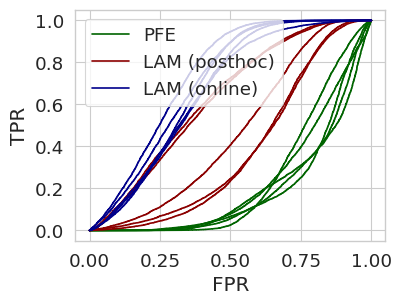

In [18]:
colors = ["darkgreen", "darkred", "darkblue"] #TODO better colors

# colors that will look good in paper
#colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig = plt.figure(figsize=(4,3))

labels = ["PFE", "LAM (posthoc)", "LAM (online)"]

data = {}
for mi, model in enumerate(["pfe", "laplace_posthoc_arccos_fix", "laplace_online_arccos_fix"]):
    #if model not in ["pfe", "laplace_posthoc_full", "laplace_online_full"]:
    #    continue
    #print(model)
    if "pred" not in all_data[model]:
        continue

    #if "arc" in model:
    #    continue
    
    for i in range(5):
        pred = all_data[model]["pred"][i]
        target = all_data[model]["target"][i]

        # plot roc curve
        roc = torchmetrics.ROC(num_classes=1)
        fpr, tpr, thresholds = roc(
            torch.tensor(pred).unsqueeze(1), torch.tensor(target).unsqueeze(1)
        )
        if model in data:
            data[model]["fpr"].append(fpr)
            data[model]["tpr"].append(tpr)
        else:
            data[model] = {"fpr" : [fpr], "tpr" : [tpr]}
            
        if i == 0:
            plt.plot(fpr, tpr, color=colors[mi], label=labels[mi])
        else:
            plt.plot(fpr, tpr, color=colors[mi])

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


/home/warburg/miniconda3/envs/py39/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


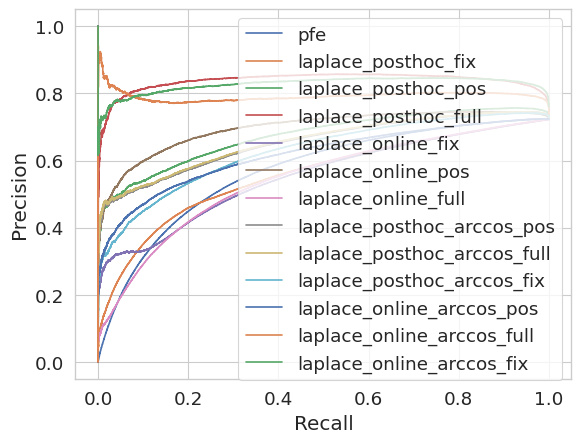

In [19]:
for model in models:
    if "pred" not in all_data[model]:
        continue
    pred = all_data[model]["pred"][0]
    target = all_data[model]["target"][0]

    # plot roc curve
    pr_curve = torchmetrics.PrecisionRecallCurve(num_classes=1)
    precision, recall, thresholds = pr_curve(
        torch.tensor(pred).unsqueeze(1), torch.tensor(target).unsqueeze(1)
    )

    plt.plot(recall, precision, label=model)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


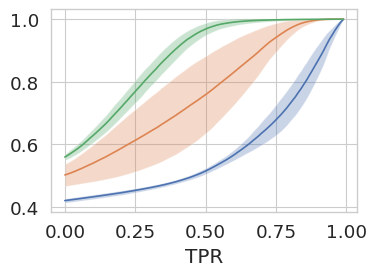

In [20]:
fig = plt.figure(figsize=(4,3))

labels = ["PFE", "LAM (posthoc)", "LAM (online)"]

fpr_bins = np.linspace(0, 1, 100)
for l, model in enumerate(["pfe", "laplace_posthoc_arccos_fix", "laplace_online_arccos_fix"]):
    tpr_avg = []
    tpr_std = []
    for b in range(100-1):
        fpr_curr = fpr_bins[b]
        fpr_next = fpr_bins[b+1]
        bin = []
        for i in range(5):
            idx = torch.logical_and(fpr_next <= data[model]["fpr"][i], data[model]["fpr"][i] >= fpr_curr)
            bin.append(torch.mean(data[model]["tpr"][i][idx]))
        tpr_avg.append(torch.mean(torch.tensor(bin)))
        tpr_std.append(torch.std(torch.tensor(bin)))
    
    tpr_avg = torch.tensor(tpr_avg)
    tpr_std = torch.tensor(tpr_std)
    
    plt.fill_between(fpr_bins[:-1], tpr_avg-tpr_std, tpr_avg+tpr_std, alpha=0.3)
    plt.plot(fpr_bins[:-1], tpr_avg, label=labels[l])

if dataset == "fashionmnist":
    plt.legend()   
    plt.ylabel("FPR") 
    
plt.xlabel("TPR")
plt.tight_layout()
plt.savefig(f"{dataset}_roc.pdf", bbox_inches='tight')
plt.show()